This is Ipopt version 3.11.9, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:       29
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        1

Total number of variables............................:       20
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       10
                     variables with only upper bounds:        0
Total number of equality constraints.................:       10
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

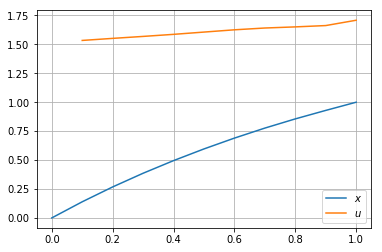

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
from pymola.backends.casadi.api import transfer_model
import numpy as np
import casadi as ca

model = transfer_model('../models/', 'Exponential', {})
dae = model.dae_residual_function
X0 = model.states[0].start

# Discretization steps
N = 10

# Discretization time step
dt = 0.1

# Optimization variables and bounds
X = ca.MX.sym('X', N)
lbX = np.full(N, -np.inf)
ubX = np.full(N, np.inf)

U = ca.MX.sym('U', N)
lbU = np.full(N, 0)
ubU = np.full(N, 1.75)

# Collocate DAE using backwards Euler method
g = []
i = 0
res = dae(0, X[0], (X[0] - X0) / dt, U[0], U[i], ca.MX(), ca.MX())
g.append(res)
for i in range(1, N):
    res = dae(i * dt, X[i], (X[i] - X[i - 1]) / dt, ca.MX(), U[i], ca.MX(), ca.MX())
    g.append(res)
    
# Optimization objective
f = (X[-1] - 1.0)**2

# Solve NLP
nlp = {'x': ca.vertcat(X, U), 'f': f, 'g': ca.vertcat(*g)}
ipopt_options = {'tol': 1e-6}
solver = ca.nlpsol('nlp', 'ipopt', nlp, {'ipopt': ipopt_options})
solution = solver(lbx=ca.vertcat(lbX, lbU), ubx=ca.vertcat(ubX, ubU), lbg=0, ubg=0)

# Plot solution
T = np.linspace(0, N * dt, N + 1)
X = solution['x'][0:N]
U = solution['x'][N:2*N]
plt.plot(T, ca.vertcat(X0, X), label="$x$")
plt.plot(T[1:], U, label="$u$")
plt.legend()
plt.grid()

In [2]:
from pymola.backends.casadi.generator import generate
from pymola.parser import parse

In [3]:
model = generate(parse("""
model Car
    input Real v, omega;
    Real theta, x1, x2;
equation
    der(theta) = omega;
    der(x1) = v*cos(theta) + 0.01*der(x2);
    der(x2) = v*sin(theta) + 0.01*der(x1) + 0.001*der(theta);
end Car;
"""), "Car")
model.dae.disp(True)

ns = 3, nx = 0, nz = 0, nq = 0, ny = 0, np = 0, nd = 0, nu = 2
Variables
  t = t
  s = [theta, x1, x2]
  u =  [omega, v]
Fully-implicit differential-algebraic equations
  0 == (der_theta-omega)
  0 == (der_x1-((v*cos(theta))+(0.01*der_x2)))
  0 == (der_x2-(((v*sin(theta))+(0.01*der_x1))+(0.001*der_theta)))


In [4]:
model.dae.make_explicit()
model.dae.disp(True)

ns = 0, nx = 3, nz = 0, nq = 0, ny = 0, np = 0, nd = 0, nu = 2
Variables
  t = t
  x = [theta, x1, x2]
  u =  [omega, v]
Differential equations
  der_theta == @1=vertsplit(ones(3x1,1nz)){0}, @2=vertsplit(ones(3x1,1nz)){1}, @3=vertsplit(ones(3x1,1nz)){2}, ((((((zeros(3x3,6nz)[:6:3] += vertcat(@1, 00, (-(0.001*@1)))[:2])[1:7:3] = zeros(2x1))[1:7:3] += vertcat(00, @2, (-(0.01*@2)))[:2])[2:8:3] = zeros(2x1))[2:8:3] += vertcat(00, (-(0.01*@3)), @3)[:2])'[0]\omega)
  der_x1 == @1=0.001, @2=vertsplit(ones(3x1,1nz)){0}, @3=vertsplit(ones(3x1,1nz)){1}, @4=vertsplit(ones(3x1,1nz)){2}, @5=(((((zeros(3x3,6nz)[:6:3] += vertcat(@2, 00, (-(@1*@2)))[:2])[1:7:3] = zeros(2x1))[1:7:3] += vertcat(00, @3, (-(0.01*@3)))[:2])[2:8:3] = zeros(2x1))[2:8:3] += vertcat(00, (-(0.01*@4)), @4)[:2])', vertsplit((@5[2:6]\(-vertcat((-(v*cos(theta))), (-((v*sin(theta))+(@1*(@5[0]\omega)))))))){0}
  der_x2 == @1=0.001, @2=vertsplit(ones(3x1,1nz)){0}, @3=vertsplit(ones(3x1,1nz)){1}, @4=vertsplit(ones(3x1,1nz)){2}, @5=((((

In [5]:
model.dae.set_start('x1', 1)

In [6]:
def sim(dae, f_p, dt=0.1, t0=0, tf=10):
    x0 = np.array(dae.start(ca.vertcat(*dae.x)))
    integ = ca.integrator('Phi', 'cvodes', {
        't': dae.t,
        'x': ca.vertcat(*dae.x),
         'p': ca.vertcat(*dae.p, *dae.u),
        'ode': ca.vertcat(*dae.ode)}, {"tf": dt})
    data = {'x': [], 't': []}
    x = x0
    t = t0
    while t + dt < tf:
        data['t'].append(t)
        data['x'].append(x)
        t += dt
        x = np.array(integ(x0=x, p=f_p(t, x))["xf"])[:, 0]

    for k in data.keys():
        data[k] = np.array(data[k])
    return data

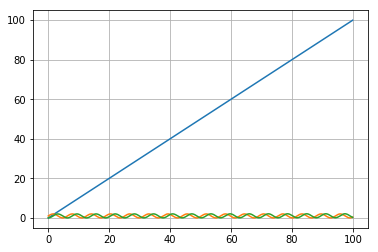

In [7]:
data = sim(model.dae, lambda t, x: [1, 1], tf=100)
plt.plot(data['t'], data['x'])
plt.grid()

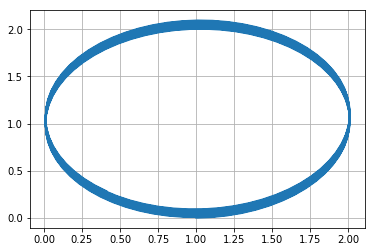

In [8]:
plt.plot(data['x'][:,1], data['x'][:,2])
plt.grid()